# Market Capitalization Data Discovery
[Portfolio Analysis](https://tradewithpython.com/portfolio-analysis-using-python)

After unzip files into folder, read all the files into a list

In [1]:
'''
    WARNING CONTROL to display or ignore all warnings
'''
import warnings; warnings.simplefilter('default')     #switch betweeb 'default' and 'ignore'

''' Set debug flag to view extended error messages; else set it to False to turn off debugging mode '''
debug = True

In [2]:
import sys
sys.path.insert(1, '../lib')
import clsDataETL as etl
import pandas as pd

if debug:
    import importlib
    etl = importlib.reload(etl)

''' Initialize the dataETL class '''
path = "../data/market_cap_2021-01-01_2022-06-01/"
clsETL = etl.ExtractLoadTransform(dataPath=path)
''' Get list of data file names '''
_l_fnames = clsETL.get_file_list()
print("Retrieved %d files in dir: %s " % (len(_l_fnames),path))
''' Load data into dataframe '''
data_df = clsETL.load_data(_l_fnames)
print("Loaded %d rows %s" % (data_df.shape[0],str(data_df.columns)))
''' Transform data with coin ids in columns '''
market_df = clsETL.transfrom_data(data_df, value_col_name='market_cap')
print(market_df.info())
print("Market cap data load & transform complete! ")

Retrieved 63 files in dir: ../data/market_cap_2021-01-01_2022-06-01/ 
Loaded 3637 rows Index(['Date', 'ID', 'Symbol', 'market_cap'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 524 entries, 0 to 523
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          524 non-null    datetime64[ns]
 1   bitcoin       524 non-null    float64       
 2   bitcoin_cash  493 non-null    float64       
 3   cardano       524 non-null    float64       
 4   ethereum      524 non-null    float64       
 5   litecoin      524 non-null    float64       
 6   ripple        524 non-null    float64       
 7   solana        524 non-null    float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 32.9 KB
None
Market cap data load & transform complete! 


## Probability distribution of the data

bitcoin
[distfit] >fit..
[distfit] >transform..
[distfit] >[norm      ] [0.00 sec] [RSS: 0.0000000] [loc=778418899104.554 scale=58437211508.392]
[distfit] >[expon     ] [0.00 sec] [RSS: 0.0000000] [loc=666220701468.485 scale=112198197636.069]
[distfit] >[pareto    ] [0.09 sec] [RSS: 0.0000000] [loc=-1481894985.333 scale=667702596427.561]
[distfit] >[dweibull  ] [0.06 sec] [RSS: 0.0000000] [loc=766565978992.041 scale=58247443081.662]
[distfit] >[t         ] [0.09 sec] [RSS: 0.0000000] [loc=2501440958.431 scale=787375509743.781]
[distfit] >[genextreme] [0.24 sec] [RSS: 0.0000000] [loc=666220701468.617 scale=2.409]
[distfit] >[gamma     ] [0.08 sec] [RSS: 0.0000000] [loc=-812940731558.978 scale=2146939942.213]
[distfit] >[lognorm   ] [0.15 sec] [RSS: 0.0000000] [loc=666220701468.484 scale=3.970]
[distfit] >[beta      ] [0.14 sec] [RSS: 0.0000000] [loc=662083273843.240 scale=253539355746.330]
[distfit] >[uniform   ] [0.00 sec] [RSS: 0.0000000] [loc=666220701468.485 scale=238331245448.836]


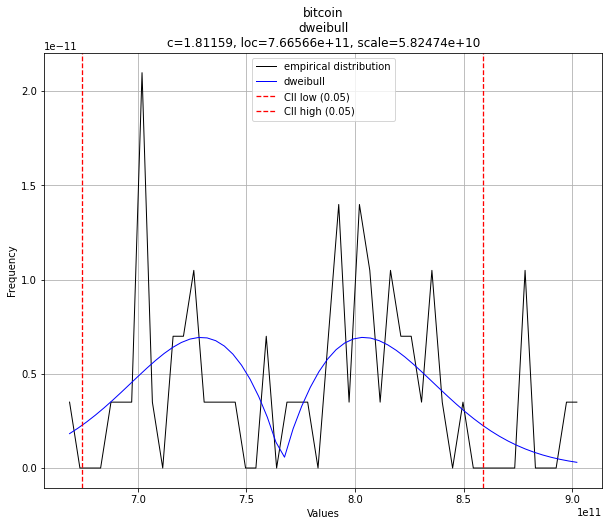

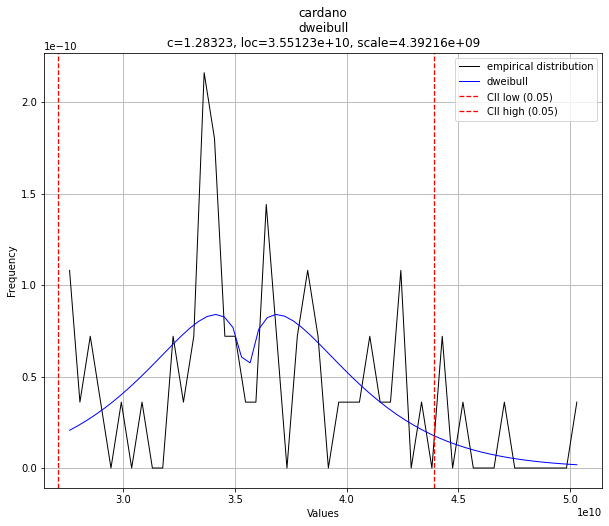

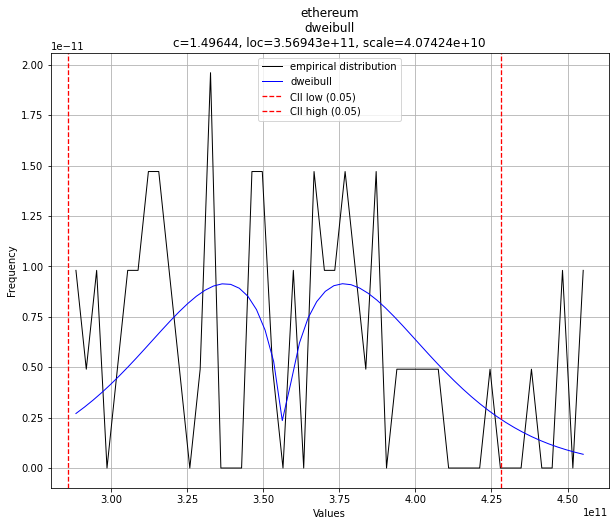

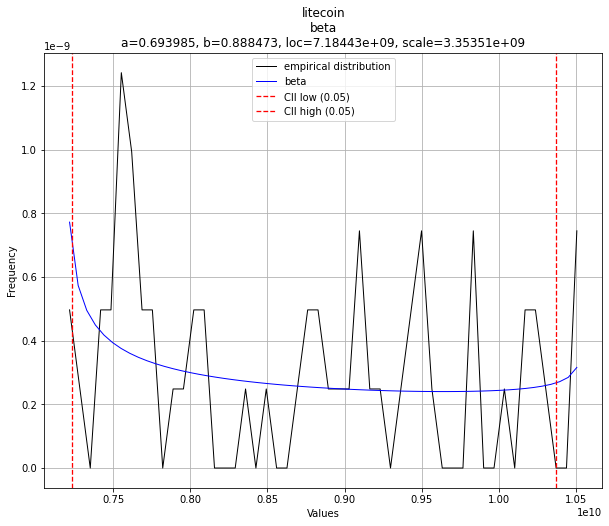

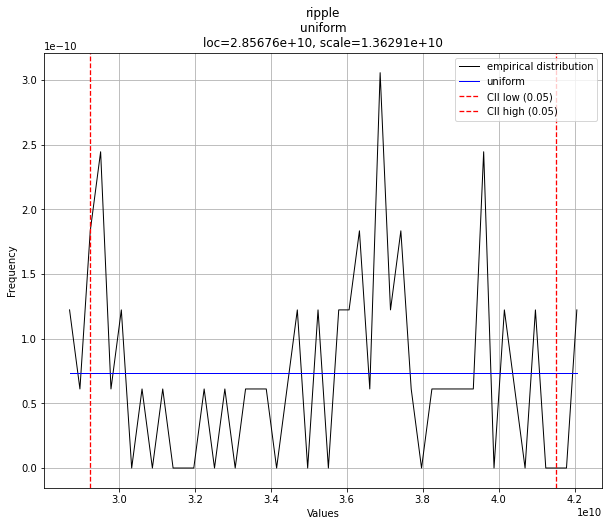

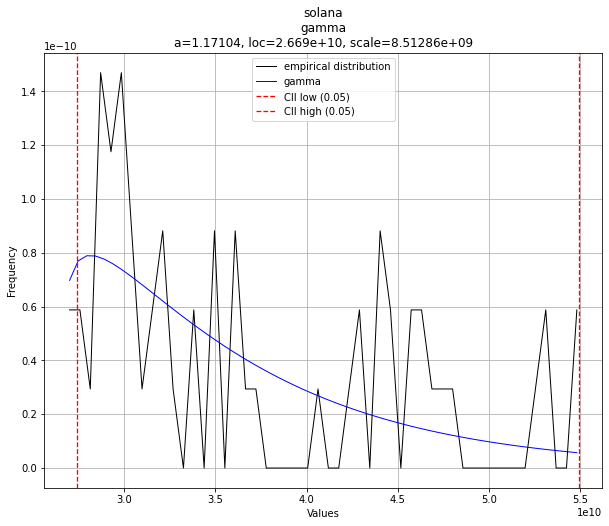

In [10]:
#%%capture
from distfit import distfit
import numpy as np

_l_dist = []
dist = distfit(distr='popular')
market_df.replace("", np.nan, inplace=True)
market_df.dropna(how='all', axis=1, inplace=True)

''' list of all the numerical data columns '''
_l_num_cols=market_df.select_dtypes(include=np.number).columns.tolist()
_l_num_cols = [col for col in _l_num_cols if col !='bitcoin_cash']
for col in _l_num_cols:
    print(col)
    _col_vals = market_df[col].values
    ''' initialize distfit'''
    dist.fit_transform(_col_vals)
    ''' print the summary results '''
    dist.plot(title=col)


## Filter by date range

In [3]:
import datetime

start_dt = datetime.datetime(2022,1,1)
end_dt = datetime.datetime(2022,3,1)
market_df=clsETL.fillter_by_date(market_df,start_dt,end_dt)
market_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60 entries, 365 to 424
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          60 non-null     datetime64[ns]
 1   bitcoin       60 non-null     float64       
 2   bitcoin_cash  59 non-null     float64       
 3   cardano       60 non-null     float64       
 4   ethereum      60 non-null     float64       
 5   litecoin      60 non-null     float64       
 6   ripple        60 non-null     float64       
 7   solana        60 non-null     float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 4.2 KB


## Market capital
Plot the market capital time series to see the behaviour

In [4]:
import plotly.express as px

market_cap_df = market_df.copy()
_min_date = (market_cap_df["Date"].min()).date()
_max_date = (market_cap_df["Date"].max()).date()
_title = "Market Capitalization from "+str(_min_date)+" to "+str(_max_date)
fig = px.scatter(market_cap_df, x="Date", y=market_cap_df.columns,
              hover_data={"Date": "|%B %d, %Y"},
              title=_title)
fig.update_xaxes(
    dtick="M1",
    tickformat="%b\n%Y")
fig.show()

/home/gnewy/.local/lib/python3.8/site-packages/plotly/io/_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



# Index by Market Caps

Apply the [custom market cap index based method](https://medium.com/python-financial-analysis/python-financial-analysis-4-3-market-cap-based-index-329b908f75dc). 
1. sort the table by the market cap in descending order
1. take just the first N rows
1. get tickers that belong to the Ns, and transform it to a list “tickers_topN”
1. iterate over the N tickers
   1. market_cap” selects a column
      1. multiply the weight “w” to created column “marketcap_weighted_ave_topN”

In [5]:
import plotly.express as px

_weighted_market_df = market_df.copy()
_min_date = (_weighted_market_df["Date"].min()).date()
_max_date = (_weighted_market_df["Date"].max()).date()
_l_coin_ids = list(_weighted_market_df.columns)
_l_coin_ids.remove('Date')

for coin in _l_coin_ids:
    weighted_col_name = "weighted_"+coin
    _weighted_market_df[weighted_col_name]=_weighted_market_df[coin]/_weighted_market_df[coin].sum()

_l_weighted_cols = [x for x in _weighted_market_df.columns if x not in _l_coin_ids]
plot_weighted_market_df = _weighted_market_df[_l_weighted_cols]

_title = "Weighted Market Capitalization Index from "+str(_min_date)+" to "+str(_max_date)
fig = px.line(plot_weighted_market_df, x="Date", y=plot_weighted_market_df.columns,
              hover_data={"Date": "|%Y-%m-%d, "},
              title=_title)
fig.update_xaxes(
    dtick="M1",
    tickformat="%b\n%Y")
fig.show()

/home/gnewy/.local/lib/python3.8/site-packages/plotly/io/_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



## Simple Returns
1. Compute the ___percentage change___ between the current and a prior value, for each coin.
1. Plot the returns to examine coins with high and low ___volatility___.

In [6]:
''' Daily simple returns '''
import datetime
import plotly.express as px

simple_returns_df = market_df.copy()
_min_date = (simple_returns_df["Date"].min()).date()
_max_date = (simple_returns_df["Date"].max()).date()

simple_returns_df = market_df[_l_coin_ids].pct_change(periods=1)
simple_returns_df["Date"] = market_df["Date"]   #.astype('datetime[ns]')

_title = "Expected Returns from "+str(_min_date)+" to "+str(_max_date)
fig = px.line(simple_returns_df, x="Date", y=simple_returns_df.columns,
              hover_data={"Date": "|%B %d, %Y"},
              title=_title)
fig.update_xaxes(
    dtick="M1",
    tickformat="%b\n%Y")
fig.show()

/home/gnewy/.local/lib/python3.8/site-packages/plotly/io/_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



## Average Daily Returns
Calculate the average daily returns for each coin

In [7]:
print('Average Daily returns(%) of coins:\n')
Avg_daily = simple_returns_df.mean()
print(Avg_daily*100)
#print(Avg_daily)

Average Daily returns(%) of coins:

bitcoin        -0.049808
bitcoin_cash         NaN
cardano        -0.423308
ethereum       -0.286689
litecoin       -0.323675
ripple          0.037348
solana         -0.678866
dtype: float64


/tmp/ipykernel_11043/3504244102.py:2: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.



## Risk of Daily Returns
The box plot will reveal the:
1. largest spread in the box plot shows the coin with the highest _average daily returns_
1. coin with the positive outliers translates into a higher average daily return

In [8]:
import plotly.express as px

_title = "Risk Box Plot from "+str(_min_date)+" to "+str(_max_date)

df = simple_returns_df[_l_coin_ids].melt(var_name="quartilemethod")

fig = px.box(df, facet_col="quartilemethod", color="quartilemethod",
             boxmode="overlay", points='all', title=_title)

for col_idx, col_name in enumerate(_l_coin_ids):
    # use: quartilemethod = {linear, inclusive, exclusive}
    fig.update_traces(quartilemethod="linear", jitter=0, col=col_idx)
fig.show()

/home/gnewy/.local/lib/python3.8/site-packages/plotly/io/_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



## Returns Per Unit Risk
1. Calculate each coins' ___standard deviation___
1. Calculate ___periodic standard deviation___ (annualized standard deviation)
1. Coin with higher ratio is better beacuse it has the best ___Return to Risk ratio___
1. Also known as the ___Sharpe Ratio___
   1. it is a measure of risk-adjusted return
   1. it describes how much excess return is  receive for the volatility of holding a riskier asset

In [13]:
from datetime import datetime
import numpy as np

#max_date = simple_returns_df['Date'].max()
#min_date = simple_returns_df['Date'].min()
Ndays = (_max_date - _min_date).days

print("Annualized Standard Deviation Volatality for %s trading days" % (str(Ndays)))
print("of individual coins on the basis of daily simple returns.")
print(simple_returns_df[_l_coin_ids].std().astype('float64')  * np.sqrt(Ndays).astype('float64') * 100.0)
#print(simple_returns_df.std() * np.sqrt(Ndays) * 100)

Annualized Standard Deviation Volatality for 31 trading days
of individual coins on the basis of daily simple returns.
bitcoin         15.461410
bitcoin_cash          NaN
cardano         29.902032
ethereum        23.998057
litecoin        22.840896
ripple          18.407503
solana          31.297766
dtype: float64


## Cummilative Product

Doesn't apply to ETP. Mainly meant for products with cummalative returns

In [17]:
import plotly.express as px

_investment = 1.0 # USD

_cum_prod_df = market_df.copy()
_l_coin_ids = [col for col in _cum_prod_df if col != 'Date']
_min_date = (_cum_prod_df["Date"].min()).date()
_max_date = (_cum_prod_df["Date"].max()).date()
_cum_prod_df = _cum_prod_df[_l_coin_ids].pct_change(periods=1)
daily_cummulative_simple_return = (_cum_prod_df[_l_coin_ids]+_investment).cumprod()
daily_cummulative_simple_return = pd.concat([daily_cummulative_simple_return,market_df['Date']],axis=1)

_title = "Daily Cummulative Simple returns/growth of investment from "\
            +str(_min_date)+" to "+str(_max_date)
fig = px.line(daily_cummulative_simple_return, x="Date", y=daily_cummulative_simple_return.columns,
              hover_data={"Date": "|%Y-%m-%d, "},
              title=_title)
fig.update_xaxes(
    dtick="M1",
    tickformat="%b\n%Y")
fig.show()

## DEPRECATED